In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
import string
from nltk.corpus import stopwords,wordnet
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [2]:
true=pd.read_csv('/content/True.csv')
fake=pd.read_csv('/content/Fake.csv')

In [3]:
true

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"
...,...,...,...,...
21412,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,"August 22, 2017"
21413,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,"August 22, 2017"
21414,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,"August 22, 2017"
21415,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,"August 22, 2017"


In [4]:
true.drop(columns=['title','subject','date'],inplace=True,)

In [5]:
fake.drop(columns=['title','subject','date'],inplace=True,)

In [6]:
true['label']=0

In [7]:
true

,text,label
0,WASHINGTON (Reuters) - The head of a conservat...,0
1,WASHINGTON (Reuters) - Transgender people will...,0
2,WASHINGTON (Reuters) - The special counsel inv...,0
3,WASHINGTON (Reuters) - Trump campaign adviser ...,0
4,SEATTLE/WASHINGTON (Reuters) - President Donal...,0
...,...,...
21412,BRUSSELS (Reuters) - NATO allies on Tuesday we...,0
21413,"LONDON (Reuters) - LexisNexis, a provider of l...",0
21414,MINSK (Reuters) - In the shadow of disused Sov...,0
21415,MOSCOW (Reuters) - Vatican Secretary of State ...,0


In [8]:
fake['label']=1

In [9]:
fake

,text,label
0,Donald Trump just couldn t wish all Americans ...,1
1,House Intelligence Committee Chairman Devin Nu...,1
2,"On Friday, it was revealed that former Milwauk...",1
3,"On Christmas day, Donald Trump announced that ...",1
4,Pope Francis used his annual Christmas Day mes...,1
...,...,...
23476,21st Century Wire says As 21WIRE reported earl...,1
23477,21st Century Wire says It s a familiar theme. ...,1
23478,Patrick Henningsen 21st Century WireRemember ...,1
23479,21st Century Wire says Al Jazeera America will...,1


In [10]:
news_df=pd.concat([true,fake],ignore_index=True)

In [11]:
news_df

,text,label
0,WASHINGTON (Reuters) - The head of a conservat...,0
1,WASHINGTON (Reuters) - Transgender people will...,0
2,WASHINGTON (Reuters) - The special counsel inv...,0
3,WASHINGTON (Reuters) - Trump campaign adviser ...,0
4,SEATTLE/WASHINGTON (Reuters) - President Donal...,0
...,...,...
44893,21st Century Wire says As 21WIRE reported earl...,1
44894,21st Century Wire says It s a familiar theme. ...,1
44895,Patrick Henningsen 21st Century WireRemember ...,1
44896,21st Century Wire says Al Jazeera America will...,1


In [12]:
news_df['label'].value_counts()

,count
label,
1,23481
0,21417


In [13]:
news_df.shape

(44898, 2)

In [16]:
news_df.duplicated().sum()

np.int64(6251)

In [17]:
news_df.drop_duplicates(inplace=True)

In [18]:
news_df.duplicated().sum()

np.int64(0)

In [28]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


True

In [29]:
stop_words=nltk.corpus.stopwords.words('english')

In [34]:
def get_wordnet_pos(tag):
  if tag.startswith('J'):
    return wordnet.ADJ
  elif tag.startswith('V'):
    return wordnet.VERB
  elif tag.startswith('N'):
    return wordnet.NOUN
  elif tag.startswith('R'):
    return wordnet.ADV
  else:
    return wordnet.NOUN

In [35]:
ln=WordNetLemmatizer()

In [36]:
def text_preprocessing(text):
  text=text.lower()
  text=text.strip()
  text=re.sub(r'[^a-zA-Z0-9\s]',"",text)
  text=re.sub(r'(\r\n|\r|\n)+','/n',text)
  token=nltk.word_tokenize(text)  # break sentence into words
  tagged_token=nltk.pos_tag(token)
  lemmatized_token=[ln.lemmatize(word,get_wordnet_pos(tag))for word,tag in tagged_token] #Lemmatizes each word (converts to base form) using its POS tag.
  filtered_tokens=[word for word in lemmatized_token if word not in stop_words] # remove stopwords
  filtered_text=" ".join(filtered_tokens)
  return filtered_text

In [37]:
news_df['cleaned_text']=news_df['text'].apply(lambda x: text_preprocessing(x))

In [41]:
positive_text=" ".join(news_df[news_df['label']==0]['cleaned_text'])

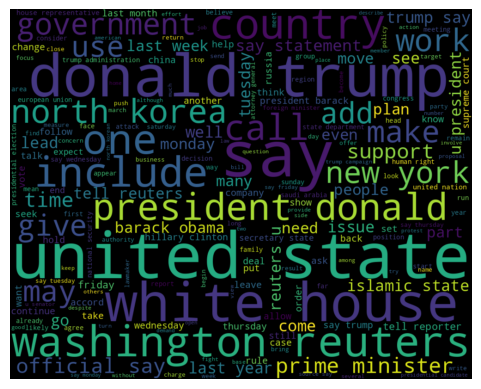

In [42]:
wc=WordCloud(width=1000,height=800).generate(positive_text)
plt.imshow(wc,interpolation='bilinear')
plt.axis('off')
plt.show()

In [43]:
fake_text=" ".join(news_df[news_df['label']==1]['cleaned_text'])

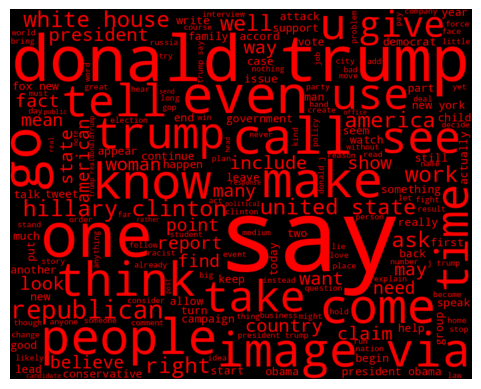

In [45]:
def red_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return "rgb(255, 0, 0)"  # pure red

wc = WordCloud(width=1000, height=800, color_func=red_color_func).generate(fake_text)
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

In [77]:
X1=news_df['cleaned_text']
y=news_df['label']

In [78]:
tdfidf=TfidfVectorizer(max_features=5000)
X=tdfidf.fit_transform(X1)

In [79]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42, stratify = y)

In [80]:
from sklearn.feature_extraction.text import TfidfTransformer

In [81]:
lr_classifier=LogisticRegression()

In [82]:
lr_classifier.fit(X_train, y_train)

LogisticRegression()

In [83]:
y_pred=lr_classifier.predict(X_test)

In [84]:
print('confusion Matrix', confusion_matrix(y_test, y_pred))
print('\n')
print(classification_report(y_test,y_pred))

confusion Matrix [[4195   44]
 [  84 3407]]


              precision    recall  f1-score   support

           0       0.98      0.99      0.98      4239
           1       0.99      0.98      0.98      3491

    accuracy                           0.98      7730
   macro avg       0.98      0.98      0.98      7730
weighted avg       0.98      0.98      0.98      7730



# Logistic Regression Using Pipeline

In [87]:
from sklearn.model_selection import train_test_split
x1_train, x1_test, y1_train, y1_test = train_test_split(X1, y, test_size = 0.2, random_state =42)

In [88]:
from sklearn.feature_extraction.text import TfidfTransformer
pp_lrclassifier=Pipeline([('bow',CountVectorizer()),('tfidf',TfidfTransformer()),('classifier',LogisticRegression())])

In [91]:
classifier_lr=pp_lrclassifier.fit(x1_train,y1_train)

In [92]:
prediction_lr=classifier_lr.predict(x1_test)

In [93]:
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
print('confusion Matrix', confusion_matrix(y1_test, prediction_lr))
print('\n')
print(classification_report(y1_test,prediction_lr))

confusion Matrix [[4198   46]
 [  79 3407]]


              precision    recall  f1-score   support

           0       0.98      0.99      0.99      4244
           1       0.99      0.98      0.98      3486

    accuracy                           0.98      7730
   macro avg       0.98      0.98      0.98      7730
weighted avg       0.98      0.98      0.98      7730



In [95]:
pp_nbclassifier=Pipeline([('bow',CountVectorizer()),('tfidf',TfidfTransformer()),('classifier',MultinomialNB())])

In [97]:
classifier_nb=pp_nbclassifier.fit(x1_train,y1_train)

In [98]:
y_pred_nb=classifier_nb.predict(x1_test)

In [99]:
print('confusion Matrix', confusion_matrix(y1_test, y_pred_nb))
print('\n')
print(classification_report(y1_test,y_pred_nb))

confusion Matrix [[4168   76]
 [ 514 2972]]


              precision    recall  f1-score   support

           0       0.89      0.98      0.93      4244
           1       0.98      0.85      0.91      3486

    accuracy                           0.92      7730
   macro avg       0.93      0.92      0.92      7730
weighted avg       0.93      0.92      0.92      7730



,cleaned_text
0,washington reuters head conservative republica...
1,washington reuters transgender people allow fi...
2,washington reuters special counsel investigati...
3,washington reuters trump campaign adviser geor...
4,seattlewashington reuters president donald tru...
...,...
44115,21st century wire say world stage men woman me...
44116,randy johnson 21st century wirethe majority ma...
44117,tune alternate current radio network acr anoth...
44118,21st century wire say new front open long batt...
